Epoch 1/5
1563/1563 [==============================] - 75s 48ms/step - loss: 1.5328 - accuracy: 0.4419 - val_loss: 1.2321 - val_accuracy: 0.5531
Epoch 2/5
1563/1563 [==============================] - 72s 46ms/step - loss: 1.1691 - accuracy: 0.5851 - val_loss: 1.2305 - val_accuracy: 0.5744
Epoch 3/5
1563/1563 [==============================] - 73s 47ms/step - loss: 1.0174 - accuracy: 0.6421 - val_loss: 0.9918 - val_accuracy: 0.6576
Epoch 4/5
1563/1563 [==============================] - 73s 46ms/step - loss: 0.9184 - accuracy: 0.6769 - val_loss: 0.9948 - val_accuracy: 0.6520
Epoch 5/5
1/1 [==============================] - 0s 75ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


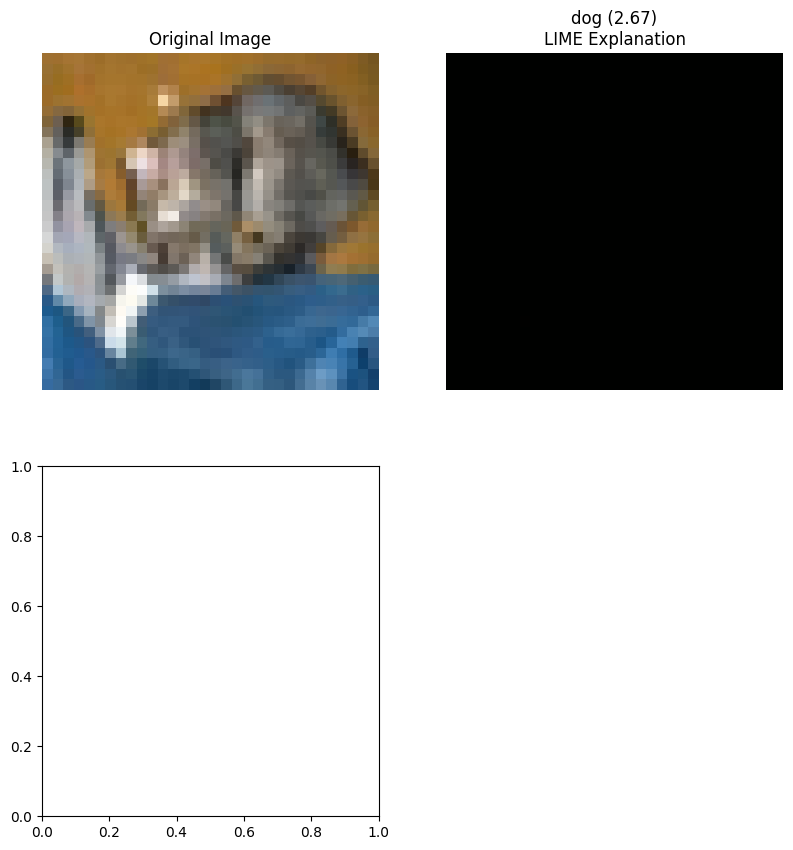

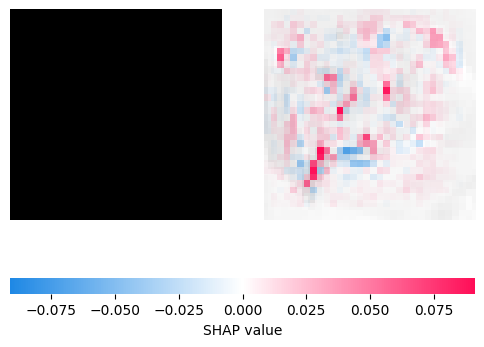

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


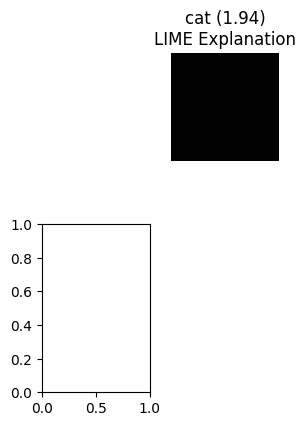

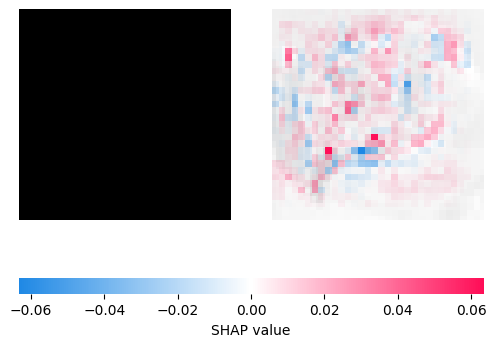

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


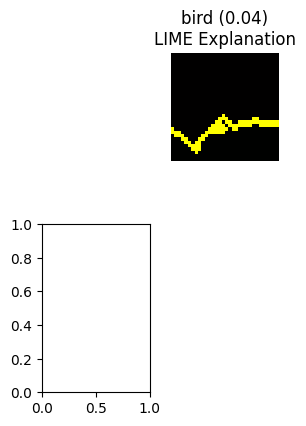

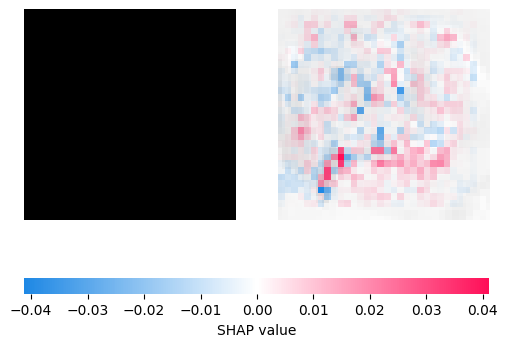

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values
train_images, test_images = train_images / 255.0, test_images / 255.0

# CIFAR-10 label names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Function to display the original image and the explanations for the top 3 predictions
def explain_prediction(image_index):
    # Get model prediction
    prediction = model.predict(np.array([test_images[image_index]]))

    # Get top 3 predictions
    top_3_indices = np.argsort(prediction[0])[-3:][::-1]
    top_3_labels = [class_names[i] for i in top_3_indices]
    top_3_scores = prediction[0][top_3_indices]

    # Display the original image
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    plt.imshow(test_images[image_index])
    plt.title("Original Image")
    plt.axis('off')

    # Loop through top 3 predictions and show explanations
    for i, label in enumerate(top_3_labels):
        # LIME Explanation
        explainer_lime = lime_image.LimeImageExplainer()
        explanation_lime = explainer_lime.explain_instance(test_images[image_index],
                                                           model.predict,
                                                           top_labels=3,
                                                           hide_color=0,
                                                           num_samples=1000)
        temp, mask = explanation_lime.get_image_and_mask(top_3_indices[i],
                                                         positive_only=False,
                                                         num_features=10,
                                                         hide_rest=False)
        plt.subplot(2, 4, i+2)
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"{label} ({top_3_scores[i]:.2f})\nLIME Explanation")
        plt.axis('off')

        # SHAP Explanation
        background = train_images[np.random.choice(train_images.shape[0], 100, replace=False)]
        explainer_shap = shap.DeepExplainer(model, background)
        shap_values = explainer_shap.shap_values(test_images[image_index:image_index+1])
        plt.subplot(2, 4, i+5)
        shap.image_plot(shap_values[top_3_indices[i]], -test_images[image_index:image_index+1])

    # Display all in one plot
    plt.tight_layout()
    plt.show()

# Test the function with an image
image_index = 0  # Choose an image index to explain
explain_prediction(image_index)
